In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATAROOT = "WIT-UAV-Dataset"
os.listdir(DATAROOT)

['2022-05-11_FIRE-SGL-111-Confluence_M600',
 '2021-11-08_FIRE-SGL-174-Rossiter_M100',
 '2022-11-08_FIRE-SGL-108-Reade-Township_M600']

- seek cameras
- FLIR cameras


per folder: 
- how many total boxes per class?
- what percentage of detections to no detections?
- visualization of detection number over time?
- size statistics of boxes?
- height of UAS?

how to ensure similar distributions of fire vs no fire?

```
WIT-UAV-Dataset
├── 2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect
│   ├── 2021-11-07_19-19-31_dji_sdk_and_thermal.repaired
│   ├── 2021-11-07_19-19-36_dji_sdk_and_thermal.repaired
│   ├── 2021-11-07_19-19-54_dji_sdk_and_thermal
│   └── 2021-11-07_19-20-26_dji_sdk_and_thermal.repaired
├── 2022-05-11_FIRE-SGL-111-Confluence_M600-Data-Collect
│   ├── seek_displayImage
│   │   ├── 2022-04-27_00-18-06
│   │   ├── 2022-04-27_00-18-47
│   │   └── 2022-04-27_00-24-53
│   └── thermal_1_image_rect
│       ├── 2022-04-27_00-18-06
│       ├── 2022-04-27_00-18-47
│       └── 2022-04-27_00-24-53
└── 2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test
    ├── 2022-11-08_13-15-55_dji_sdk_and_thermal
    ├── 2022-11-08_14-13-12_dji_sdk_and_thermal
    └── 2022-11-08_14-40-21_dji_sdk_and_thermal.kinda-repaired-images-only_labeled
```

In [3]:
list_of_runs = []
for dirpath, dirnames, filenames in os.walk(DATAROOT):
    if not dirnames:
        list_of_runs.append(dirpath)
        print(dirpath, "has 0 subdirectories and", len(filenames), "files")
list_of_runs = sorted(list_of_runs)

WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_flir has 0 subdirectories and 1184 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_seek has 0 subdirectories and 1303 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_seek has 0 subdirectories and 2182 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_flir has 0 subdirectories and 1177 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_seek has 0 subdirectories and 1585 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_flir has 0 subdirectories and 1227 files
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-36_flir has 0 subdirectories and 515 files
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-20-26_flir has 0 subdirectories and 207 files
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19

In [4]:
list_of_runs

['WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-31_flir',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-36_flir',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-54_flir',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-20-26_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_seek',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_seek',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_seek',
 'WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11-08_13-15-55_seek',
 'WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11

In [5]:
run = list_of_runs[1]

In [6]:
run

'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-36_flir'

In [7]:
def count_detections_per_class(path):
    num_v = 0
    num_h = 0
    with open(path, "r") as f:
        lines = f.readlines()
        # if len(lines) == 0:
        #     print(lines)
        #     raise ValueError(f"File {path} is empty")
        for line in lines:
            if "v" in line or "c" in line:
                num_v += 1
            elif "h" in line:
                num_h += 1
            else:
                print(lines)
                raise ValueError(f"File {path} has no class")
    return num_v, num_h

In [8]:
def count_run_stats(run):
    num_total = 0
    num_labeled = 0
    total_num_v = 0
    total_num_h = 0
    width, height = 0, 0
    for f in os.listdir(run):
        if "label" in f: # is label file
            num_v, num_h = count_detections_per_class(run + "/" + f)
            total_num_v += num_v
            total_num_h += num_h

            if num_v > 0 or num_h > 0:
                num_labeled += 1
        else: # is image file
            if width == 0: # if resolution is not set, then set it
                # find resolution from image file
                img = cv2.imread(run + "/" + f)
                width, height, _ = img.shape
            num_total += 1
    
    # print(f"resolution={width}, {height}")
    # print(f"{num_total=}, {num_labeled=}, {total_num_v=}, {total_num_h=}")
    # print(f"percentage labeled={num_labeled/num_total}")
    return num_total, num_labeled, total_num_v, total_num_h, width, height

In [9]:
# pandas dataframe to store information about each run
df = pd.DataFrame(columns=["folder", "num_total", "num_labeled", "total_num_v", "total_num_h", "resolution"])

for run in list_of_runs:
    num_total, num_labeled, total_num_v, total_num_h, width, height = count_run_stats(run)
    # folder name is the run name minus the path
    folder = run.split("/")[-1]
    df = pd.concat([df, pd.DataFrame({"folder": folder, "num_total": num_total, "num_labeled": num_labeled, "total_num_v": total_num_v, "total_num_h": total_num_h, "resolution": f"{width}x{height}"}, index=[0])], ignore_index=True)

df.head()

,folder,num_total,num_labeled,total_num_v,total_num_h,resolution
0,2021-11-07_19-19-31_flir,368,47,36,176,512x640
1,2021-11-07_19-19-36_flir,469,46,101,59,512x640
2,2021-11-07_19-19-54_flir,49,22,0,33,512x640
3,2021-11-07_19-20-26_flir,150,54,0,137,512x640
4,2022-04-27_00-18-06_flir,974,49,50,0,512x640


Total percent labelled: 29.645063945969248 %


,folder,num_total,num_labeled,total_num_v,total_num_h,resolution,percentage_labeled
0,2021-11-07_19-19-31_flir,368,47,36,176,512x640,12.771739
1,2021-11-07_19-19-36_flir,469,46,101,59,512x640,9.808102
2,2021-11-07_19-19-54_flir,49,22,0,33,512x640,44.897959
3,2021-11-07_19-20-26_flir,150,54,0,137,512x640,36.0
4,2022-04-27_00-18-06_flir,974,49,50,0,512x640,5.030801


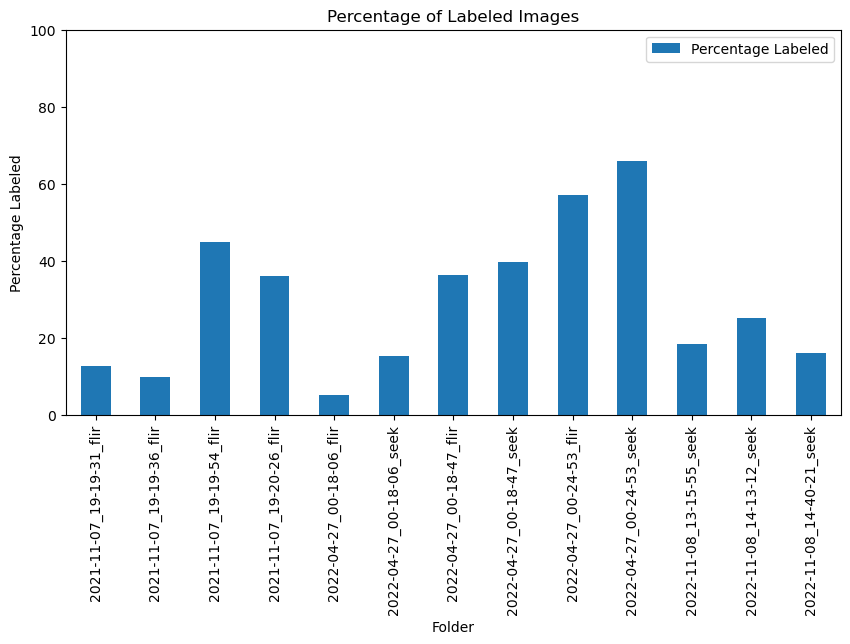

In [10]:
# find percentage of labeled images
df["percentage_labeled"] = df["num_labeled"] / df["num_total"] * 100
# find total percentage of labeled images
total_labeled = df["num_labeled"].sum() / df["num_total"].sum()
print(f"Total percent labelled: {total_labeled * 100} %")
# plot percentage of labeled images vs folder. y scale is 0 to 100
df.plot(x="folder", y="percentage_labeled", kind="bar", figsize=(10, 5), ylim=(0, 100), title="Percentage of Labeled Images", ylabel="Percentage Labeled", xlabel="Folder")
plt.legend(["Percentage Labeled"])
df.head()

Total number of vehicles: 5030
Total number of humans: 1543


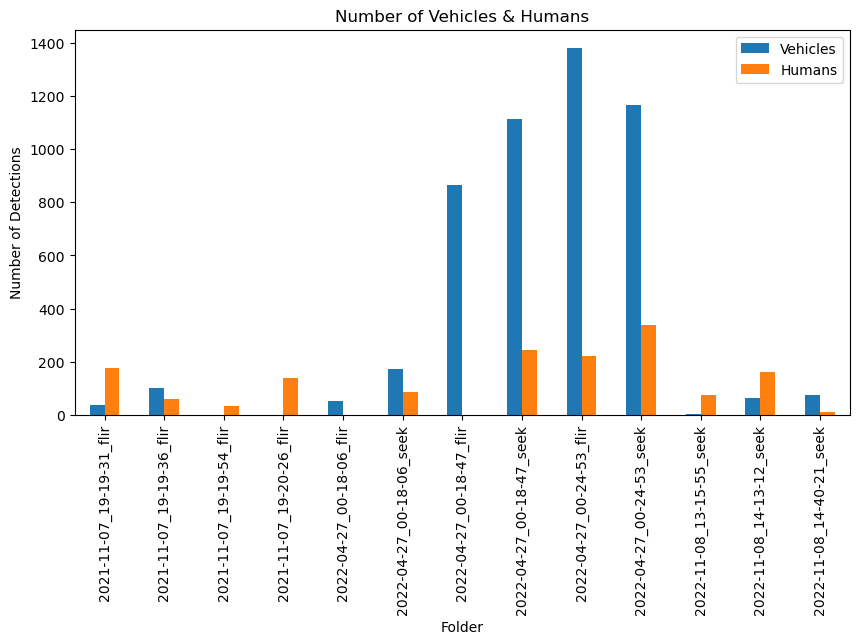

In [11]:
# plot number of vehicles and humans vs folder
# legend is number of vehicles and humans
df.plot(x="folder", y=["total_num_v", "total_num_h"], kind="bar", figsize=(10, 5), title="Number of Vehicles & Humans" , ylabel="Number of Detections", xlabel="Folder", legend=True)
plt.legend(["Vehicles", "Humans"])

# find total number of vehicles and humans
total_num_v = df["total_num_v"].sum()
total_num_h = df["total_num_h"].sum()
print(f"Total number of vehicles: {total_num_v}")
print(f"Total number of humans: {total_num_h}")


Total number of 240x320 images: 3510
Total number of 512x640 images: 3449
Total number of 240x320 labeled images: 1172
Total number of 512x640 labeled images: 891


<BarContainer object of 2 artists>

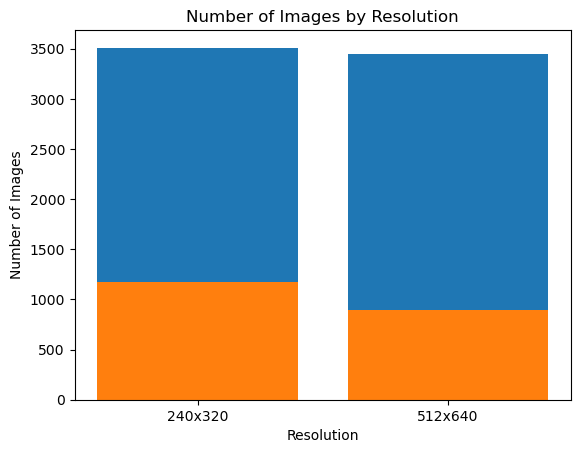

In [12]:
# find total number of 240x320 images
total_240x320 = df[df["resolution"] == "240x320"]["num_total"].sum()

# find total number of 512x640 images
total_512x640 = df[df["resolution"] == "512x640"]["num_total"].sum()

print(f"Total number of 240x320 images: {total_240x320}")
print(f"Total number of 512x640 images: {total_512x640}")

# plot number of 240x320 and 512x640 images calculated above with x,y labels and title
plt.bar(["240x320", "512x640"], [total_240x320, total_512x640])
plt.title("Number of Images by Resolution")
plt.xlabel("Resolution")
plt.ylabel("Number of Images")

# find total number of 240x320 labeled images
total_240x320_labeled = df[df["resolution"] == "240x320"]["num_labeled"].sum()

# find total number of 512x640 labeled images
total_512x640_labeled = df[df["resolution"] == "512x640"]["num_labeled"].sum()

print(f"Total number of 240x320 labeled images: {total_240x320_labeled}")
print(f"Total number of 512x640 labeled images: {total_512x640_labeled}")

# plot number of 240x320 and 512x640 labeled images calculated above with x,y labels and title
plt.bar(["240x320", "512x640"], [total_240x320_labeled, total_512x640_labeled])



The train val test data should have roughly the same distribution of humans to vehicles. But ideally they come from different runs to show generalization.

Actually we're not trying to show generalization. We're just trying to contribute a new dataset. Leave generalization for later

# Train/Val/Test Split

70 15 15

10 files
7 train
1 val
2 test (flip these

In [13]:
print(DATAROOT)

WIT-UAV-Dataset


In [14]:
from glob import glob
glob(DATAROOT+"/**/.png", recursive=True)

[]

In [15]:
train_files = []
val_files = []
test_files = []

import random
from itertools import zip_longest

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def swap(a, b):
    return b, a

for run in list_of_runs:
    print("------")
    print(run)
    
    files_of_10 = chunker([run + "/" + fi for fi in os.listdir(run) if fi.endswith(".png")], 10)
    
    num_val = 2
    
    
    for ten_files in files_of_10:
        shuffled = list(ten_files)
        random.shuffle(shuffled)
        trains = shuffled[:7]
        vals = shuffled[7:7+num_val]
        tests = shuffled[7+num_val:]
        
        train_files += trains
        val_files += vals
        test_files += tests
        num_val = 3 - num_val

------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-31_flir
------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-36_flir
------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-54_flir
------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-20-26_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_seek
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_seek
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_seek
------
WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11-08_13-15-55_seek
------
WIT-UAV-Dataset/2022-11-08_FI

In [16]:
len(train_files), len(val_files), len(test_files)

(4877, 1043, 1031)

In [17]:

test_files += val_files[-6:]
val_files = val_files[:-6]

In [18]:
len(val_files), len(test_files)

(1037, 1037)

In [19]:
import shutil

def copy_out(files, output_path):
    
    for t in files:
        t_no_parent_folder = t[len(DATAROOT):]
        target_file = f"{output_path}/" + t_no_parent_folder
        print("copy", t, "to", target_file)
        os.makedirs(os.path.dirname(target_file), exist_ok=True)
        shutil.copyfile(t, target_file)

        label_file = t[:-4]  + ".label"
        if os.path.isfile(label_file):
            target_file = f"{output_path}/" + label_file[len(DATAROOT):]
            print("copy", label_file, "to", target_file)
            os.makedirs(os.path.dirname(target_file), exist_ok=True)
            shutil.copyfile(label_file, target_file)

In [20]:
# copy_out(train_files, "train")
# copy_out(val_files, "val")
# copy_out(test_files, "test")